In [1]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns

# Settings
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)


# seed = randint(0, int(1e6))
# print(seed)
# seed = 715440  # for commented out sizes below gets 85% missingness.
seed = 691309  # for reduced sizes, gets 74% missingness.

pyro.set_rng_seed(seed)

# Partial Missingness and Informative Data
In this notebook, we'll establish a simple causal model where some of the data is missing. We expect that the data-sensitivity should be larger for data with no missingness, and smaller — but still non-zero — for data with missingness. 

In [2]:
# VEC_DIM = -1
# MAT_DIM = -2
DATA_DIM = -1
MC_DIM = -2
# NUM_CONFOUNDERS = 107
NUM_CONFOUNDERS = 3
NUM_OUTCOME = 1
# NUM_TREATMENT = 27
NUM_TREATMENT = 1


def missingness_likelihood_model(
        treatment_coefficients,  # (..., NUM_CONFOUNDERS, NUM_TREATMENT)
        confounder_coefficients,  # (..., NUM_CONFOUNDERS, 1)
        missingness_coefficients,  # (..., NUM_CONFOUNDERS + NUM_TREATMENT, 1)
        outcome_coefficients  # (..., NUM_CONFOUNDERS + NUM_TREATMENT, NUM_OUTCOME)
):
    
    assert treatment_coefficients.shape[-2:] == (NUM_CONFOUNDERS, NUM_TREATMENT),\
        f"Treatment coefficients shape: {treatment_coefficients.shape}"
    assert confounder_coefficients.shape[-2:] == (NUM_CONFOUNDERS, 1),\
        f"Confounder coefficients shape: {confounder_coefficients.shape}"
    assert missingness_coefficients.shape[-2:] == (NUM_CONFOUNDERS + NUM_TREATMENT, 1),\
        f"Missingness coefficients shape: {missingness_coefficients.shape}"
    assert outcome_coefficients.shape[-2:] == (NUM_CONFOUNDERS + NUM_TREATMENT, NUM_OUTCOME),\
        f"Outcome coefficients shape: {outcome_coefficients.shape}"
    
    confounders = pyro.sample("conf", dist.Normal(confounder_coefficients, 1).to_event(2))
    assert confounders.shape[-2:] == (NUM_CONFOUNDERS, 1), f"Confounders shape: {confounders.shape}"
    
    treatment_means = treatment_coefficients.transpose(-2, -1) @ confounders
    assert treatment_means.shape[-2:] == (NUM_TREATMENT, 1), f"Treatment means shape: {treatment_means.shape}"
    
    treatment = pyro.sample("treat", dist.Normal(treatment_means, 1).to_event(2))
    assert treatment.shape[-2:] == (NUM_TREATMENT, 1), f"Treatment shape: {treatment.shape}"
    
    # HACK treatment may have been intervened on and have had dimensions added on the left. This breaks the cats below.
    # To resolve, expand the left dimensions of the confounders to match the treatment dimensions.
    expanded_confounders = confounders
    if len(treatment.shape) > len(confounders.shape):
        num_added_left_dims = treatment.ndim - confounders.ndim
        for _ in range(num_added_left_dims):
            expanded_confounders = expanded_confounders[None, ...]
        expanded_confounders = expanded_confounders.expand(treatment.shape[:num_added_left_dims] + (-1,) * confounders.ndim)
        
    missingness_logit = missingness_coefficients.transpose(-2, -1) @ torch.cat([expanded_confounders, treatment], dim=-2)
    assert missingness_logit.shape[-2:] == (1, 1), f"Missingness logit shape: {missingness_logit.shape}"
    
    missingness = pyro.sample("miss", dist.Bernoulli(logits=missingness_logit).to_event(2))
    # This might be fixed now due to changes elsewhere.
    # # HACK Similar to above, if an intervention has been performed, the missingness may have been properly expanded.
    # if missingness.ndim < missingness_logit.ndim:
    #     while missingness.ndim < missingness_logit.ndim:
    #         missingness = missingness[None, ...]
    #     missingness = missingness.expand_as(missingness_logit)
    
    assert missingness.shape[-2:] == (1, 1), f"Missingness shape: {missingness.shape}. Missingness logit shape: {missingness_logit.shape}"
    
    outcome_means = outcome_coefficients.transpose(-2, -1) @ torch.cat([expanded_confounders, treatment], dim=-2)
    assert outcome_means.shape[-2:] == (NUM_OUTCOME, 1), f"Outcome means shape: {outcome_means.shape}"
    
    # HACK to make outcome still be computationally non-deterministic (so we can condition on it) when missingness is zero.
    outcome = pyro.sample("out", dist.Normal(outcome_means * missingness, 1. * missingness + 1e-3).to_event(2))
    assert outcome.shape[-2:] == (NUM_OUTCOME, 1), f"Outcome shape: {outcome.shape}"
    
    return dict(
        conf=confounders,
        treat=treatment,
        miss=missingness,
        out=outcome
    )

In [3]:
def coefficient_prior():
    # with pyro.plate("conf_plate", NUM_CONFOUNDERS, dim=MAT_DIM):
    confounder_coefficients = pyro.sample("confounder_coefficients", dist.Normal(0, 1.)
                                          .expand((NUM_CONFOUNDERS, 1)).to_event(2))
    
    # with pyro.plate("treat_plate", NUM_TREATMENT, dim=VEC_DIM):
    treatment_coefficients = pyro.sample("treatment_coefficients", dist.Normal(0., 1)
                                         .expand((NUM_CONFOUNDERS, NUM_TREATMENT)).to_event(2))
    
    # with pyro.plate("conf_treat_plate", NUM_CONFOUNDERS + NUM_TREATMENT, dim=MAT_DIM):
    missingness_coefficients = pyro.sample("missingness_coefficients", dist.Normal(0., 1.)
                                           .expand((NUM_CONFOUNDERS + NUM_TREATMENT, 1)).to_event())
        
        # with pyro.plate("out_plate", NUM_OUTCOME, dim=VEC_DIM):
    outcome_coefficients = pyro.sample("outcome_coefficients", dist.Normal(0., 1.)
                                       .expand((NUM_CONFOUNDERS + NUM_TREATMENT, NUM_OUTCOME)).to_event())
    
    return dict(
        confounder_coefficients=confounder_coefficients,
        treatment_coefficients=treatment_coefficients,
        missingness_coefficients=missingness_coefficients,
        outcome_coefficients=outcome_coefficients
    )

In [4]:
def full_missingness_model(num_data=1):
    coefficients = coefficient_prior()
    
    with pyro.plate("data", num_data, dim=DATA_DIM):
        return missingness_likelihood_model(**coefficients), coefficients

In [5]:
NOBSERVED = 200
observed_data, true_coefficients = full_missingness_model(NOBSERVED)
print("Observed data shapes:")
print('\n'.join([str((k, v.shape)) for k, v in observed_data.items()]))
print("True coefficients shapes:")
print('\n'.join([str((k, v.shape)) for k, v in true_coefficients.items()]))

Observed data shapes:
('conf', torch.Size([200, 3, 1]))
('treat', torch.Size([200, 1, 1]))
('miss', torch.Size([200, 1, 1]))
('out', torch.Size([200, 1, 1]))
True coefficients shapes:
('confounder_coefficients', torch.Size([3, 1]))
('treatment_coefficients', torch.Size([3, 1]))
('missingness_coefficients', torch.Size([4, 1]))
('outcome_coefficients', torch.Size([4, 1]))


In [6]:
print(f"Missingness rate: {1. - observed_data['miss'].mean().item():.2%}")

Missingness rate: 74.00%


In [7]:
# for treatment_idx in range(NUM_TREATMENT):
#     plt.scatter(observed_data["treat"].detach()[..., treatment_idx, 0], observed_data["out"].detach()[..., 0, 0], c=observed_data["miss"].detach()[..., 0, 0])
#     plt.xlabel("Treatment")
#     plt.ylabel("Outcome")
#     plt.title(f"Treatment {treatment_idx}")
#     plt.show()

### Stochastic Variational Inference

In [8]:
conditioned_missingness_model = condition(partial(full_missingness_model, NOBSERVED), data=observed_data)

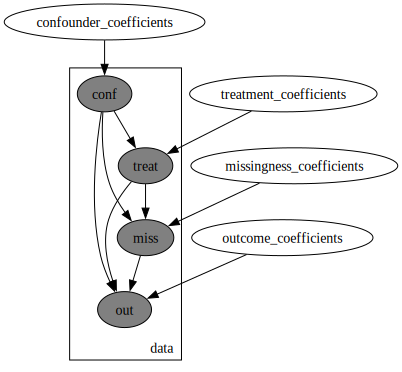

In [9]:
pyro.render_model(conditioned_missingness_model)

In [10]:
svi = build_svi_iter(
    conditioned_missingness_model,
    # AutoMultivariateNormal,
    AutoDelta,
    lr=2e-3
)
# NITER = 100
NITER = 4000
for i in range(NITER):
    svi.svi_iter()
    print(f"Progress {(i+1)/NITER:.2%}", end="\r")

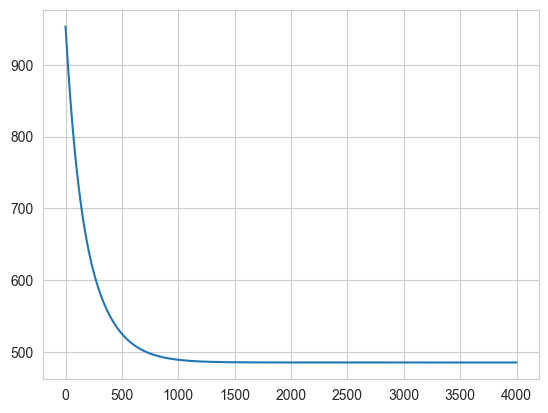

In [11]:
plt.plot(svi.losses)

### Check Performance of Plug-In Estimator


In [65]:
class MultivariateTreatmentGrid(torch.nn.Module):
    def __init__(self, model, values, num_monte_carlo: int = 100, results_shaper=None, constant_idices=None, generate_product_values=False):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
        self.results_shaper = results_shaper or (lambda x: x)
        self.constant_idices = constant_idices or {}
        
        if generate_product_values:
            # Expand values over the grid of treatments.
            product_values = []
            for value in product(values, repeat=NUM_TREATMENT):
                # [:, None] to Specify as column vector.
                product_values.append(torch.tensor(value)[:, None])
            assert len(product_values) == 2 ** NUM_TREATMENT
            
            self.product_values = tuple(product_values)
        else:
            # [:, None] to Specify as column vector.
            self.product_values = tuple(v[:, None] for v in values)
    
    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=MC_DIM):
                with do(actions=dict(treat=self.product_values)):
                    predictive_samples, coefficient_samples = self.model(*args, **kwargs)
                    Ys = predictive_samples["out"]
                
                outs = []
                for i, _ in enumerate(self.product_values):
                    idx_set = IndexSet(treat={i+1}, **self.constant_idices)
                    outs.append(gather(Ys, idx_set, event_dim=2))
                    
        return self.results_shaper(outs)

In [13]:
def reshape_results_to_mean(results):
    results = torch.cat(results, dim=0)  # (len(product_values), ..., num_monte_carlo, num_data, NUM_OUTCOME, 1)
    return results.squeeze(-1).mean(-2).mean(-2).reshape(-1, NUM_OUTCOME)  # (len(product_values), ..., NUM_OUTCOME)

def reshape_results_to_estimates(results):
    results = torch.cat(results, dim=0)  # (len(product_values), ..., num_monte_carlo, num_data, NUM_OUTCOME, 1)
    results = results.squeeze(-1).transpose(-1, 1)  # (len(product_values), ...,  NUM_OUTCOME, num_monte_carlo, num_data)
    return results.reshape(results.shape[:2] + (-1,))  # (len(product_values), NUM_OUTCOME, num_monte_carlo * num_data)

NMC = 1e4
NBD = 1
# intervention_values = (-10., 10.)
intervention_values = (torch.ones(NUM_TREATMENT) * -10., torch.ones(NUM_TREATMENT) * 10.)

In [14]:
full_missingness_model_wo_missingness = do(full_missingness_model, {"miss": torch.tensor(1.)[None, None]})

In [15]:
true_model = condition(full_missingness_model_wo_missingness, data=true_coefficients)
true_results_estimates = MultivariateTreatmentGrid(
    true_model,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1}),
    results_shaper=reshape_results_to_estimates
)(num_data=NBD)
print(true_results_estimates.shape)

torch.Size([2, 1, 10000])


In [16]:
posterior_predictive_model = PredictiveModel(full_missingness_model_wo_missingness, svi.guide)
posterior_result_estimates = MultivariateTreatmentGrid(
    posterior_predictive_model,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1}),
    results_shaper=reshape_results_to_estimates
)(num_data=NBD)
print(posterior_result_estimates.shape)

torch.Size([2, 1, 10000])


In [17]:
prior_predictive_model = full_missingness_model
prior_result_estimates = MultivariateTreatmentGrid(
    full_missingness_model_wo_missingness,
    intervention_values,
    num_monte_carlo=NMC,
    constant_idices=dict(miss={1}),
    results_shaper=reshape_results_to_estimates
)(num_data=NBD)
print(prior_result_estimates.shape)

torch.Size([2, 1, 10000])


In [18]:
colors = ["blue", "orange", "black"]
def plot_intervention_outcome_grid(*results):
    num_interventions = results[0].shape[0]
    num_outcomes = results[0].shape[1]
    fig, axs = plt.subplots(num_outcomes, num_interventions, figsize=(num_interventions * 7, num_outcomes * 7), sharey=True, sharex=True)
    
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    if axs.ndim == 1:
        axs = axs[None, :]
    
    for i, j in product(range(num_interventions), range(num_outcomes)):
        
        for result, color in zip(results, colors):
            sns.kdeplot(result[i, j].detach().numpy(), ax=axs[j, i], fill=False, color=color, linewidth=0.6)
            mean = result[i, j].mean().item()
            axs[j, i].axvline(mean, color=color, linestyle="--", linewidth=0.6)
        
        
    return fig, axs

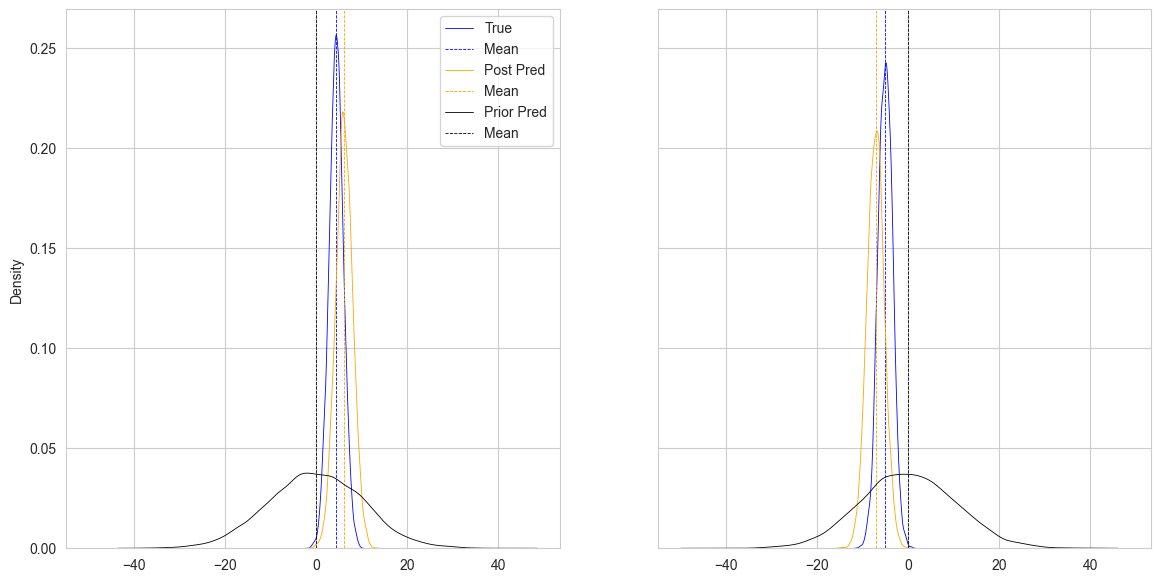

In [19]:
_, axs = plot_intervention_outcome_grid(true_results_estimates, posterior_result_estimates, prior_result_estimates)
# Add legend to the first plot.
axs[0, 0].legend(["True", "Mean", "Post Pred", "Mean", "Prior Pred", "Mean"])

# TODO Add Robust Estimator to Above

### First, gradcheck

In [66]:
# First, we want to gradcheck the functional of the posterior predictive wrt the guide parameters.
from torch.autograd import gradcheck

# def testing_fn(*args, **kwargs):
#     print(*args, **kwargs)
#     posterior_predictive_model(*args, **kwargs)

fn_to_gradcheck = MultivariateTreatmentGrid(
    # Emulate returned coefficient samples with ..., None
    lambda *args: (missingness_likelihood_model(*args), None),
    intervention_values,
    num_monte_carlo=10,
    # constant_idices=dict(miss={1}),  # not performing this intervention...
    # results_shaper=reshape_results_to_estimates
    results_shaper=None
)
def fixed_noise_fn_to_gradcheck(*args):
    pyro.set_rng_seed(0)  # fix noise in the random samples for numerical gradcheck.
    return fn_to_gradcheck(*args)

params_to_gradcheck = tuple(v.detach().clone().requires_grad_() for v in svi.guide().values())

gradcheck(fixed_noise_fn_to_gradcheck, params_to_gradcheck)

True

In [89]:
# Gradcheck just the return values of missingness_likelihood_model. We'll need a wrapper fn to flatten and cat the returned dictionary.
def missingness_likelihood_model_wrapper(*args):
    pyro.set_rng_seed(0)  # fix noise in the random samples for numerical gradcheck.
    
    # Interven on missingness, as we can't differentiate through this
    with do(actions=dict(miss=torch.tensor(1.)[None, None])):
        return tuple(missingness_likelihood_model(*args).values())

gradcheck(missingness_likelihood_model_wrapper, params_to_gradcheck)

True

In [91]:
# Now, just see what the gradients are for the missingness model. Use the function defined above, and just print the jacobians.
# First, import the jacobian computation function.
from torch.autograd.functional import jacobian

out_keys = ["conf", "treat", "miss", "out"]
in_keys = ["treatment_coefficients", "confounder_coefficients", "missingness_coefficients", "outcome_coefficients"]
# Then, compute the jacobian of the missingness model wrt its parameters.
jacs = jacobian(missingness_likelihood_model_wrapper, params_to_gradcheck)

for i, (out_key, jac) in enumerate(zip(out_keys, jacs)):
    print(f"change in {out_key}")
    for j, (in_key, jac_in) in enumerate(zip(in_keys, jac)):
        print(f"    wrt change in {in_key}")
        print("    ", jac_in.shape)
        print("    ", jac_in.squeeze())

change in conf
    wrt change in treatment_coefficients
     torch.Size([3, 1, 3, 1])
     tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
    wrt change in confounder_coefficients
     torch.Size([3, 1, 3, 1])
     tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
    wrt change in missingness_coefficients
     torch.Size([3, 1, 4, 1])
     tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
    wrt change in outcome_coefficients
     torch.Size([3, 1, 4, 1])
     tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
change in treat
    wrt change in treatment_coefficients
     torch.Size([1, 1, 3, 1])
     tensor([ 1.0940,  0.5515, -2.5772])
    wrt change in confounder_coefficients
     torch.Size([1, 1, 3, 1])
     tensor([-0.0809, -0.9327,  0.7377])
    wrt change in missingness_coefficients
     torch.Size([1, 1, 4, 1])
     tensor([0., 0., 0., 0.])
    wrt change in outcome_coefficients
     

In [ ]:
# Mystery
# 1. [/] why is the numeric gradient going completely crazy. — analytical needs noise fixed.
# 2. why is the analytic gradient correct for the latter fn where we just make a simple confounder sampler...
# 3. ...but wrong for the former, where we extract the confounders from the original function (which should have an identical compute graph to the latter).

### Estimation

In [ ]:
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator

predictive = posterior_predictive_model

# We need to make a functional that takes a model and returns a callable "estimator"
functional = partial(
    MultivariateTreatmentGrid,
    values=intervention_values,
    num_monte_carlo=1000,
    constant_idices=dict(miss={1}),
    results_shaper=reshape_results_to_mean
)

# Sample some more test data from the true model.
held_out_observed_data, _ = condition(full_missingness_model, data=true_coefficients)(num_data=10000) # NOBSERVED)

In [ ]:
compute_influence = influence_fn(
    functional,
    held_out_observed_data,
)(predictive)

# with MonteCarloInfluenceEstimator(num_samples_inner=112, num_samples_outer=96):
with MonteCarloInfluenceEstimator(num_samples_inner=1000, num_samples_outer=1000):
    with torch.no_grad():
        influence = compute_influence()

In [ ]:
influence.shape

In [ ]:
{k: v.shape for k, v in held_out_observed_data.items()}

In [ ]:
missingness = held_out_observed_data['miss'].squeeze().bool()
influence_of_present = influence[missingness, :, :]
influence_of_missing = influence[~missingness, :, :]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("Influence of Missing Data on Estimand")
axs[0].hist(influence_of_missing.detach().flatten())

axs[1].set_title("Influence of Present Data on Estimand")
axs[1].hist(influence_of_present.detach().flatten())

print("Mean Absolute Influence w/ Missingness", influence_of_missing.abs().mean())
print("Mean Absolute Influence w/o Missingness", influence_of_present.abs().mean())

In [ ]:
from chirho.robust.handlers.estimators import one_step_corrected_estimator

corrected_functional = one_step_corrected_estimator(functional, held_out_observed_data)
corrected_estimator = corrected_functional(predictive)

with MonteCarloInfluenceEstimator(num_samples_inner=1000, num_samples_outer=1000):
    with torch.no_grad():
        corrected_estimate = corrected_estimator()

In [ ]:
corrected_estimate.shape

In [ ]:
_, axs = plot_intervention_outcome_grid(true_results_estimates, posterior_result_estimates)
# Add legend to the first plot.
axs[0, 0].axvline(corrected_estimate[0, 0, 0], color="cyan")
axs[0, 0].legend(["True", "Mean", "Post Pred", "Mean", "Corrected"])
axs[0, 1].axvline(corrected_estimate[0, 1, 0], color="cyan")